In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import random

from matplotlib.ticker import ScalarFormatter  # 导入ScalarFormatter

from scipy.stats import linregress
from scipy.linalg import eig

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller

plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持显示中文
plt.rcParams['axes.unicode_minus'] = False  # 支持显示负号
warnings.filterwarnings("ignore")  # 忽略警告信息，使输出更清洁

df = pd.read_csv('events-US-1980-2021.csv', header=0)
df['Name'] = [i.split('(')[0] for i in df['Name']]  # 删除名称中的括号，方便分析
df

,Name,Disaster,Begin Date,End Date,Total CPI-Adjusted Cost (Millions of Dollars),Deaths
0,Southern Severe Storms and Flooding,Flooding,19800410,19800417,2473.8,7
1,Hurricane Allen,Tropical Cyclone,19800807,19800811,2012.0,13
2,Central/Eastern Drought/Heat Wave,Drought,19800601,19801130,36573.0,1260
3,Florida Freeze,Freeze,19810112,19810114,1864.7,0
4,"Severe Storms, Flash Floods, Hail, Tornadoes",Severe Storm,19810505,19810510,1268.6,20
...,...,...,...,...,...,...
318,Hurricane Nicholas,Tropical Cyclone,20210914,20210918,1056.6,0
319,"Southeast, Central Tornado Outbreak",Severe Storm,20211210,20211210,3993.3,93
320,Midwest Derecho and Tornado Outbreak,Severe Storm,20211215,20211215,1817.6,1
321,Western Drought and Heat Wave,Drought,20210101,20211231,9105.6,229


In [2]:
df['year'] = [int(str(i)[:4]) for i in df['Begin Date']]  # 取日期前四位，作为灾害发生年份

disaster_num = df.groupby('Disaster').count()['Name']  # 灾害发生总数

cost_num = df.groupby('Disaster').sum()['Total CPI-Adjusted Cost (Millions of Dollars)']  # 灾害损失总数

death_num = df.groupby('Disaster').sum()['Deaths']  # 灾害死亡总数

cost_num_year = df.groupby('year').sum()['Total CPI-Adjusted Cost (Millions of Dollars)']  # 灾害损失总数（按年统计）

death_num_year = df.groupby('year').sum()['Deaths']  # 灾害死亡总数（按年统计）

In [3]:
result = adfuller(cost_num_year)
print("ADF Test Statistic: %f" % result[0])  # 测试统计量
print("p-value: %f" % result[1])  # p值

# 根据p值判断数据稳定性
if result[1] > 0.05:
    print("\n数据不稳定，需要差分")
else:
    print("\n数据稳定，适合进行时间序列分析")

ADF Test Statistic: -4.759697
p-value: 0.000065

数据稳定，适合进行时间序列分析


In [6]:
scaler = MinMaxScaler()

# data.values.reshape(-1, 1)确保数据是二维的，因为scaler需要二维输入
cost_scaled = pd.DataFrame(scaler.fit_transform(cost_num_year.values.reshape(-1, 1)))

最小AIC值的参数(p, d, q): (2, 2, 2)


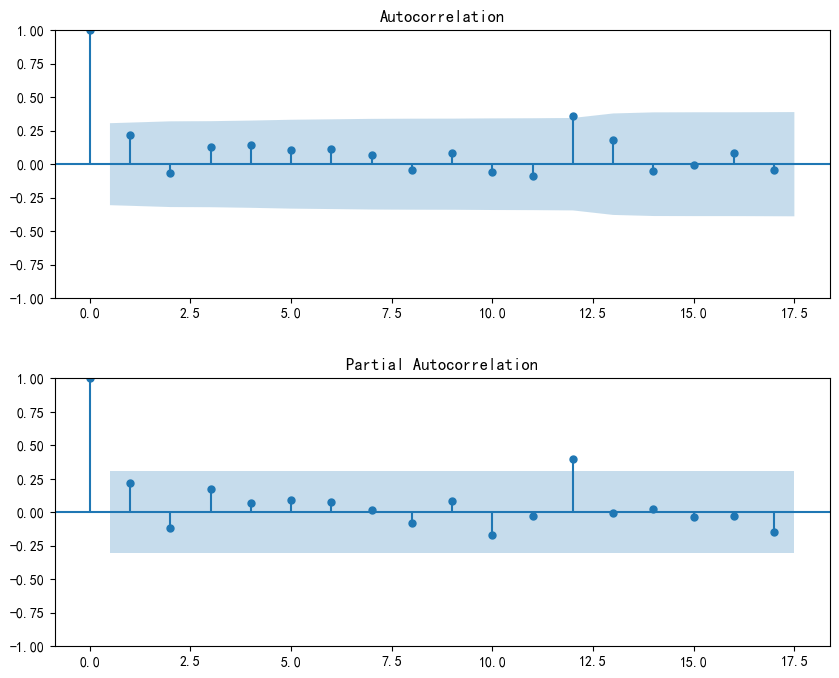

In [7]:
aic_values = {}
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = ARIMA(cost_num_year, order=(p, d, q))
                result = model.fit()
                aic_values[(p, d, q)] = result.aic  # 存储每个模型的AIC值
            except:
                continue  # 如果模型无法拟合，则继续尝试下一组参数

# 从aic_values中找到最小AIC值的参数
min_aic = min(aic_values, key=aic_values.get)
print("最小AIC值的参数(p, d, q):", min_aic)

# 打印自相关系数图和偏自相关系数图
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(cost_scaled, ax=axes[0])
plot_pacf(cost_scaled, ax=axes[1])
plt.subplots_adjust(hspace=0.3)
plt.savefig(f'（美国）损失自相关偏自相关图.png',dpi=500)
plt.show()

In [33]:
model1 = ARIMA(cost_num_year, order=(2, 2, 2))
result1 = model1.fit()
# 获取未来7年的损失预测及其95%置信区间
forecast_obj1 = result1.get_forecast(steps=7)
forecast_ci1 = forecast_obj1.conf_int()

# 创建预测结果的DataFrame，包含年份、预计损失以及置信区间
result_df1 = pd.DataFrame({'year': range(2022, 2029), 'cost': forecast_obj1.predicted_mean})
result_df1['下限95%置信区间'] = forecast_ci1.iloc[:, 0]
result_df1['上限95%置信区间'] = forecast_ci1.iloc[:, 1]

In [65]:
cost_num_year_df = cost_num_year.reset_index()
cost_num_year_df.columns = ['year', 'cost']

# 合并预测结果和历史损失数据
# 这里我们需要确保result_df已经正确包含'年份'和'预计损失'列
merged_df1 = pd.merge(cost_num_year_df, result_df, on='year', how='outer')
merged_df1['cost'] = merged_df1['cost_x'].fillna(merged_df1['cost_y'])

# 删除原有的cost_x和cost_y列
merged_df1.drop(['cost_x', 'cost_y'], axis=1, inplace=True)
merged_df1

,year,下限95%置信区间,上限95%置信区间,cost
0,1980,NaN,NaN,41058.800000
1,1981,NaN,NaN,3133.300000
2,1982,NaN,NaN,13661.600000
3,1983,NaN,NaN,22902.800000
4,1984,NaN,NaN,2893.100000
5,1985,NaN,NaN,20264.800000
6,1986,NaN,NaN,6049.100000
7,1988,NaN,NaN,49009.700000
8,1989,NaN,NaN,36270.600000
9,1990,NaN,NaN,13129.400000


In [66]:

# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 注意：MinMaxScaler期望2D数据，所以我们需要先将'death'列转换成2D
# 将None值转换为np.nan，因为MinMaxScaler不接受None值
merged_df1['cost'] = merged_df1['cost'].replace({None: np.nan})
merged_df1.dropna(inplace=True)  # 删除任何包含NaN的行

# 归一化'death'列
merged_df1['cost_normalized'] = scaler.fit_transform(merged_df1[['cost']])

# 显示处理后的DataFrame
merged_df1

,year,下限95%置信区间,上限95%置信区间,cost,cost_normalized
41,2022,-21673.395301,276530.893408,127428.749054,0.111738
42,2023,-28542.958182,274670.100483,123063.571150,0.000000
43,2024,-16641.479523,288353.633222,135856.076850,0.327458
44,2025,-7962.982799,298826.415736,145431.716469,0.572571
45,2026,-7026.216737,307412.768300,150193.275782,0.694455
46,2027,-4639.580053,315635.692045,155498.055996,0.830245
47,2028,-635.297985,324894.748636,162129.725326,1.000000


In [12]:
result = adfuller(death_num_year)
print("ADF Test Statistic: %f" % result[0])  # 测试统计量
print("p-value: %f" % result[1])  # p值

# 根据p值判断数据稳定性
if result[1] > 0.05:
    print("\n数据不稳定，需要差分")
else:
    print("\n数据稳定，适合进行时间序列分析")

ADF Test Statistic: -6.998598
p-value: 0.000000

数据稳定，适合进行时间序列分析


In [13]:
# data.values.reshape(-1, 1)确保数据是二维的，因为scaler需要二维输入
death_scaled = pd.DataFrame(scaler.fit_transform(death_num_year.values.reshape(-1, 1)))

最小AIC值的参数(p, d, q): (0, 2, 2)


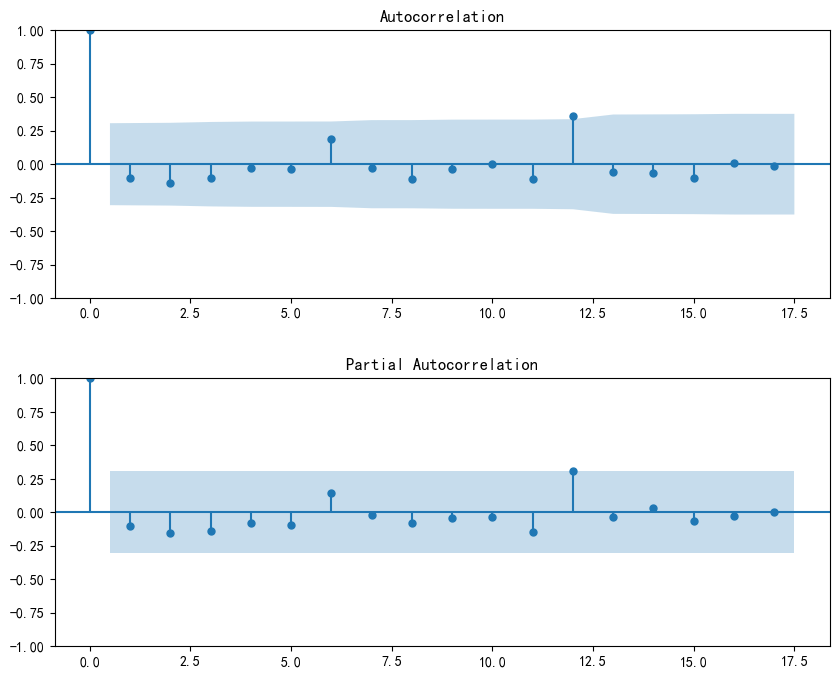

In [17]:
aic_values = {}
for p in range(3):
    for d in range(3):
        for q in range(3):
            try:
                model = ARIMA(death_num_year, order=(p, d, q))
                result = model.fit()
                aic_values[(p, d, q)] = result.aic  # 存储每个模型的AIC值
            except:
                continue  # 如果模型无法拟合，则继续尝试下一组参数

# 从aic_values中找到最小AIC值的参数
min_aic = min(aic_values, key=aic_values.get)
print("最小AIC值的参数(p, d, q):", min_aic)

# 打印自相关系数图和偏自相关系数图
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(death_scaled, ax=axes[0])
plot_pacf(death_scaled, ax=axes[1])
plt.subplots_adjust(hspace=0.3)
plt.savefig(f'（美国）死亡自相关偏自相关图.png',dpi=500)
plt.show()

In [41]:
model2 = ARIMA(death_num_year, order=(0, 2, 2))
result2 = model2.fit()
# 获取未来7年的损失预测及其95%置信区间
forecast_obj2 = result2.get_forecast(steps=7)
forecast_ci2 = forecast_obj2.conf_int()

# 创建预测结果的DataFrame，包含年份、预计损失以及置信区间
result_df2 = pd.DataFrame({'year': range(2022, 2029), 'death': forecast_obj2.predicted_mean})
result_df2['下限95%置信区间'] = forecast_ci2.iloc[:, 0]
result_df2['上限95%置信区间'] = forecast_ci2.iloc[:, 1]

In [68]:
death_num_year_df = death_num_year.reset_index()
death_num_year_df.columns = ['year', 'death']

# 合并预测结果和历史损失数据
# 这里我们需要确保result_df已经正确包含'年份'和'预计损失'列
merged_df2 = pd.merge(death_num_year_df, result_df2, on='year', how='outer')
merged_df2['death'] = merged_df2['death_x'].fillna(merged_df2['death_y'])

# 删除原有的cost_x和cost_y列
merged_df2.drop(['death_x', 'death_y'], axis=1, inplace=True)
merged_df2

,year,下限95%置信区间,上限95%置信区间,death
0,1980,NaN,NaN,1280.000000
1,1981,NaN,NaN,20.000000
2,1982,NaN,NaN,243.000000
3,1983,NaN,NaN,172.000000
4,1984,NaN,NaN,81.000000
5,1985,NaN,NaN,379.000000
6,1986,NaN,NaN,113.000000
7,1988,NaN,NaN,454.000000
8,1989,NaN,NaN,228.000000
9,1990,NaN,NaN,30.000000


In [71]:
# 初始化MinMaxScaler
scaler = MinMaxScaler()

# 注意：MinMaxScaler期望2D数据，所以我们需要先将'death'列转换成2D
# 将None值转换为np.nan，因为MinMaxScaler不接受None值
merged_df2['death'] = merged_df2['death'].replace({None: np.nan})
merged_df2.dropna(inplace=True)  # 删除任何包含NaN的行

# 归一化'death'列
merged_df2['death_normalized'] = scaler.fit_transform(merged_df2[['death']])

# 显示处理后的DataFrame
merged_df2

,year,下限95%置信区间,上限95%置信区间,death,death_normalized
41,2022,-608.458763,1826.849998,609.195617,0.000000
42,2023,-583.591533,1855.236633,635.822550,0.166667
43,2024,-560.198000,1885.096966,662.449483,0.333333
44,2025,-538.633613,1916.786444,689.076416,0.500000
45,2026,-519.240815,1950.647512,715.703348,0.666667
46,2027,-502.343823,1987.004385,742.330281,0.833333
47,2028,-488.243157,2026.157584,768.957214,1.000000


In [75]:
t=1
t_ = 2021 + t

S = merged_df1.loc[merged_df1['year'] == t_, 'cost'].values[0]

D = merged_df2.loc[merged_df2['year'] == t_, 'death'].values[0]

M = 1 / (1 + S + D)
M

7.81012372891272e-06

In [76]:
import numpy as np

# 参数范围设定
P_range = (3000, 6000)
Ca_range = (90000, 110000)
i_values = [0.02, 0.03, 0.04]
Cf_range = (850000, 1000000)
Cv_range = (80, 100)
t_range = [1, 2, 3, 4, 5, 6, 7]
Q_range = (0, 600000)
rc = 0.0415

# 种群大小、交叉率和变异率
population_size = 150
crossover_rate = 0.7
mutation_rate = 0.08
generations = 2000

def initialize_population():
    return np.random.rand(population_size, 7)

def decode_chromosome(chromosome):
    P = int(np.round(P_range[0] + (P_range[1] - P_range[0]) * chromosome[0]))
    Ca = int(np.round(Ca_range[0] + (Ca_range[1] - Ca_range[0]) * chromosome[1]))
    i = i_values[int(np.floor(chromosome[2] * len(i_values)))]
    Cf = int(np.round(Cf_range[0] + (Cf_range[1] - Cf_range[0]) * chromosome[3]))
    Cv = int(np.round(Cv_range[0] + (Cv_range[1] - Cv_range[0]) * chromosome[4]))
    t = t_range[int(np.floor((t_range[-1] - t_range[0]) * chromosome[5])) % len(t_range)]
    Q = int(np.round(Q_range[0] + (Q_range[1] - Q_range[0]) * chromosome[6]))
    return P, Ca, i, Cf, Cv, t, Q

def fitness_function_updated(chromosome):
    P, Ca, i, Cf, Cv, t, Q = decode_chromosome(chromosome)
    t_ = 2021 + t

    S = merged_df1.loc[merged_df1['year'] == t_, 'cost_normalized'].values[0]

    D = merged_df2.loc[merged_df2['year'] == t_, 'death_normalized'].values[0]

    M = 1 / (1 + S + D)

    profit = P * Q - Cf - Cv * Q - (rc * Q * Ca *(1 / (1 + i)**t)) / M
    return profit if profit > 0 else 0

def select(population, fitness):
    # 轮盘赌选择
    fitness_sum = np.sum(fitness)
    if fitness_sum == 0:
        return population
    probs = fitness / fitness_sum
    indices = np.random.choice(population_size, size=population_size, replace=True, p=probs)
    return population[indices]

def crossover(parent1, parent2):
    if np.random.rand() < crossover_rate:
        point = np.random.randint(1, len(parent1)-1)
        child1 = np.concatenate((parent1[:point], parent2[point:]))
        child2 = np.concatenate((parent2[:point], parent1[point:]))
        return child1, child2
    else:
        return parent1, parent2

def mutate(chromosome):
    for i in range(len(chromosome)):
        if np.random.rand() < mutation_rate:
            chromosome[i] = np.random.rand()
    return chromosome

def genetic_algorithm():
    population = initialize_population()
    global_best_fitness = -np.inf
    global_best_solution = None
    for generation in range(generations):
        fitness = np.array([fitness_function_updated(chrom) for chrom in population])
        best_index = np.argmax(fitness)
        if fitness[best_index] > global_best_fitness:
            global_best_fitness = fitness[best_index]
            global_best_solution = population[best_index].copy()
        population = select(population, fitness)
        offspring = []
        for i in range(0, population_size, 2):
            parent1, parent2 = population[i], population[i+1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            offspring.append(child1)
            offspring.append(child2)
        population = np.array(offspring)
    return global_best_solution, global_best_fitness

best_solution, best_fitness = genetic_algorithm()
P, Ca, i, Cf, Cv, t, Q = decode_chromosome(best_solution)
print(f"最优解的参数: P={P}, Ca={Ca}, i={i}, Cf={Cf}, Cv={Cv}, t={t}, Q={Q}")
print(f"最优解的利润: {best_fitness}")

最优解的参数: P=5996, Ca=90001, i=0.04, Cf=890139, Cv=80, t=1, Q=599851
最优解的利润: 1152814855.7482944
